SciDB and Python
====

> **Jonathan Rivers, Paradigm4, jrivers@paradigm4.com**

> **Kriti Sen, Paradigm4, ksen@paradigm4.com**

> **Bryan Lewis, Paradigm4, blewis@paradigm4.com**

www.paradigm4.com

$$\,$$

$$\,$$



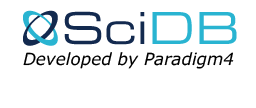

In [10]:
from IPython.display import Image
Image(filename='scidb.png')


$$\,$$

Introduction to SciDB-py package, and SciDB as a Tick database
====

* https://github.com/Paradigm4/TAQ/blob/master/TAQ_ipynb.ipynb

* https://github.com/paradigm4/SciDB-py
* http://www.paradigm4.com/forum
* http://www.paradigm4.com

  
$$\,$$



Loading the scidbpy package and connecting to SciDB
====

This step requires a connection to a SciDB cluster. This notebook assumes SciDB is available at http://localhost:8080. Replace this address with one that points to a SciDB connection.

Ready-to-roll SciDB AMIs for Amazon EC2 are available. Information is available on the SciDB forum at http://www.paradigm4.com.

In [51]:
import numpy as np
from scidbpy import interface, SciDBQueryError, SciDBArray
sdb = interface.SciDBShimInterface('http://localhost:8080')

Creating SciDB array objects...
====
...from a numpy array
----

In [34]:
X = np.random.random((5, 4))

In [36]:
X_sci = sdb.from_array(X)

In [37]:
# SciDBArray objects provide a mix of familiar numpy things and some SciDB-specific things:
X_sci.shape      # The usual shape

(5, 4)

In [38]:
X_sci.name       # SciDB array name

'py1101086155612_00002'

...using an array generating function
----

In [40]:
# Create a 10x10 array of double-precision zeros:
A = sdb.zeros( (10,10,) )

# Create a 10x10 array of 64-bit signed integer ones:
B = sdb.ones( (10,10), dtype='int64' )

# Create a 10x10 array of numbers between -1 and 2 (inclusive) sampled from a uniform random distribution.
C = sdb.random( (10,10), lower=-1, upper=2)

# Create a vector of 5 equally spaced numbers between 1 and 10, including the endpoints:
D = sdb.linspace(1,10,num=5,endpoint=True)

# Create a 10x10 sparse, double-precision-valued identity matrix:
E = sdb.identity(10, dtype='double', sparse=True)

...from a SciDB query
----

The scidbpy package query method simplifies writing low-level SciDB AFL queries involving SciDBArray objects.

In [28]:
tridiag = sdb.new_array((10, 10))
sdb.query('store(build({A}, \
                 iif({A.d0}={A.d1}, 2, -1), \
                 {A.d0} <= {A.d1}+1 and {A.d0} >= {A.d1}-1), \
           {A})', A=tridiag)
tridiag.nonempty()

28

...from an existing SciDB array
----

This example array holds one day of ARCA consolidated quote data. It has about 185 million elements.

In [55]:
quotes = sdb.wrap_array(scidbname="arca_seq")
quotes.count()[0]

185857392

The scope of SciDB arrays connected to SciDBArray objects
----
The `persistent` argument of the `new_array` method determines if a SciDB array should be removed when its corresponding Python reference falls out of scope.

In [59]:
X = sdb.random((10,10), persistent=False)
Y = X

xname = X.name
print(xname)

py1101086155612_00022


In [60]:
# Now let's delete the variable X:
del(X)

# and check to see if its array is still in SciDB:
sdb.list_arrays().has_key(xname)

True

In [61]:
# OK, let's delete the other reference to the SciDB array:
del(Y)

# and check to see if its array is still in SciDB:
sdb.list_arrays().has_key(xname)

False

Materializing data to Python
====

In [29]:
# Materialize SciDB array to Python as a numpy array:
tridiag.toarray()

array([[ 2., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [-1.,  2., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0., -1.,  2., -1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0., -1.,  2., -1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0., -1.,  2., -1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., -1.,  2., -1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0., -1.,  2., -1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., -1.,  2., -1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  2., -1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  2.]])

In [83]:
# Materialize SciDB array to Python as a sparse array:
from scipy import sparse
tridiag.tosparse('csr')

<10x10 sparse matrix of type '<type 'numpy.float64'>'
	with 28 stored elements in Compressed Sparse Row format>

Operations on `SciDBArray` objects
====
Subarrays
----

In [23]:
# Define a 3x10 subarray (returned as a new SciDBArray object)
X = tridiag[2:5,:]
X.toarray()

array([[ 0., -1.,  2., -1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0., -1.,  2., -1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0., -1.,  2., -1.,  0.,  0.,  0.,  0.]])

In [24]:
X = tridiag[2:5,::2]
X.toarray()

array([[ 0.,  2.,  0.,  0.,  0.],
       [ 0., -1., -1.,  0.,  0.],
       [ 0.,  0.,  2.,  0.,  0.]])

Data aggregation
----

In [30]:
# Sum over all elements in 'tridiag'
tridiag.sum()[0]

2.0

In [31]:
# Compute the variance along dimension 1 (columns)
tridiag.var(1).toarray()

array([ 4.5,  3. ,  3. ,  3. ,  3. ,  3. ,  3. ,  3. ,  3. ,  4.5])

...also `min` `max` `std` `mean` `approxdc` and `count`.

Shape and layout functions
----

In [94]:
tri_reshape = tridiag.reshape((20,5))
print tri_reshape.shape
print tri_reshape.transpose().shape

(20, 5)
(5, 20)


Arithmetic
----

In [25]:
X = sdb.from_array(np.random.random((10,10)))
Y = sdb.from_array(np.random.random((10,10)))

S = X + Y
D = X - Y
M = 2 * X
(S + D - M).sum()[0]

-4.4408920985006262e-16

In [26]:
sdb.dot(X,Y)

SciDBArray('not empty py1101266337305_00044<multiply:double> [i0=0:9,1000,0,i1=0:9,1000,0]')

In [27]:
sdb.dot(X.T, Y[:,1]).toarray()

array([ 1.88774937,  1.7899071 ,  2.02491303,  1.72463329,  2.58387152,
        1.70449874,  1.0778353 ,  2.45668368,  1.43828023,  1.75958135])

Broadcasting
----
We center a matrix by subtracting from each column its mean (also illustrating the aggregates along a coordinate axis):

In [30]:
# Create a small test array with 5 columns:
X = sdb.random((10,5))

# Create a vector of column means directly using a SciDB aggregation function:
xcolmean = X.mean(1)

# Subtract the column means from the original matrix using broadcasting:
XC = X - xcolmean

# Check the mean of one of the columns of the centered matrix:
XC.mean(1).toarray()

array([ -7.77156117e-17,  -7.21644966e-17,  -1.11022302e-17,
        -3.88578059e-17,  -3.88578059e-17])

$$\,$$
Putting things together for...
====
Covariance and correlation matrices
----

In [ ]:
# Create a small test array with 5 columns:
X = sdb.from_array(np.random.random((10,5)))

# Create a second small test array with 10 columns:
Y = sdb.from_array(np.random.random((10,10)))

# Subtract the column means from X using broadcasting:
xcolmean = X.mean(1)
XC = X - xcolmean

# Similarly subtract the column means from Y:
ycolmean = Y.mean(1)
YC = Y - ycolmean

# Compute the covariance matrix between X and Y:
COV = sdb.dot(XC.T, YC)/(X.shape[0] - 1)

# Column vector with column standard deviations of X matrix:
xsd = X.std(1).reshape((5,1))
# Row vector with column standard deviations of Y matrix:
ysd = Y.std(1).reshape((1,10))
# Their outer product (outer is not yet overloaded in the package):
outersd = sdb.dot(xsd,ysd)

# Element-wise division of the matrices gives us the correlation between X and Y:
COR = COV/outersd

$$\,$$
$$\,$$

# SciDB as a Tick Database 

### Connect to the SciDB DBMS

The below imports the required libraries and establishes connectivity to the SciDB DBMS. 

In [1]:
import datetime
import numpy as np
from scidbpy import interface, SciDBQueryError, SciDBArray
import matplotlib.pyplot as plt
from scidbpy import connect
import time

#sdb = connect('http://localhost:5959')
#afl = sdb.afl
 
sdb = connect("http://10.0.20.185:8080")
afl = sdb.afl

Computing best bid/offer and order books
----
https://github.com/Paradigm4/orderbook-example

SciDB can be extended using any language, as long as it's C++. (That's not quite true, we're working on ways to extend internal SciDB functionality with Python and R.)

arca is a time by symbol data matrix,
ms is the name of the time dimension,
order_records is a specially formatted string input attribute for orderbook.
The orderbook function expects the input attribute to have the following special string form:

order_type, ref_id, price, size, symbol, ask_bid_type|

In [3]:
sdb.query("load_library('nbbo')")
import time
start_time = time.time()
sdb.query("variable_window(arca, ms, 1, 0, nbbo(order_records))")
print(time.time() - start_time)

46.5135610104


In [52]:
nbbo = sdb._execute_query("variable_window(  \
                        between(arca,'DEXO',34200000,'DEXO',57600000), \
                        ms,1,0,nbbo(order_records))",response=True,fmt="lcsv+").split("\n")[1:-1]

In [53]:
nbbo = [tuple(double(y) for y in x.replace("'","").split(",")[1:]) for x in nbbo]
nbbo[0:4]

[(34200057.0, 1.6399999999999999, 480.0, 1.97, 480.0),
 (34200641.0, 1.6399999999999999, 480.0, 1.97, 480.0),
 (34202223.0, 1.6399999999999999, 480.0, 1.97, 480.0),
 (34202411.0, 1.6399999999999999, 480.0, 1.8700000000000001, 1000.0)]

The output is a 2-d array with the same dimensions as the input array and a single string attribute with the format

bp1, bv1, bp2, bv2, bp3, bv3 |  ap1, av1, ap2, av2, ap3, av3
where, bp1 means "bid price 1", "bv1 means bid volume 1", and ap1 and av1 are similarly defined for ask prices and volumes, and bp1 < bp2 < bp3 < ap1 < ap2 < ap3.

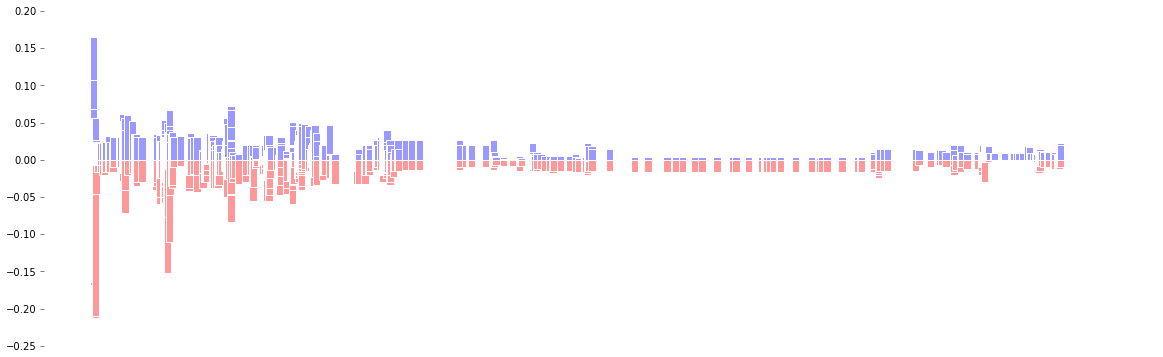

In [67]:
import matplotlib.pyplot as plt

# Data to be represented
markettime = [x[0]/60000 for x in nbbo]

avolwtspread = [(x[3]-x[1])*x[2]/(x[2] + x[4]) for x in nbbo]
bvolwtspread = [-(x[3]-x[1])*x[4]/(x[2] + x[4]) for x in nbbo]

fig = plt.figure(figsize=(20,6),facecolor="white")
axes = plt.subplot(111, axisbelow=True)

plt.bar(markettime, avolwtspread, width=3, facecolor='#9999ff', edgecolor='white')
plt.bar(markettime, bvolwtspread, width=3, facecolor='#ff9999', edgecolor='white')

axes.set_xticks([])

axes.spines['top'].set_color('none')
axes.spines['left'].set_color('none')
axes.spines['right'].set_color('none')
axes.spines['bottom'].set_color('none')
axes.yaxis.set_ticks_position('left')
plt.show()

### Parallel loading in SciDB using the accelerated load tools. 


The SciDB Enterprise Edition includes the aio_input operator which allows the ingest of files from around the file system of a distributed cluster. You have the ability to pick a number of paths and the SciDB instance number. Each selected SciDB instance will load from the corresponding data path. This can provide the benefit of loading from multiple IO devices. 

In [ ]:
sdb.query('
insert(
        redimension(
                project(
                        apply(                 
                            cast(
           
aio_input('paths=/scidbData/importFifo1;/scidbData/importFifo2;'
          ,'instances=3;21;','num_attributes=5','attribute_delimiter=,')

                            ,<_security_id:string null,_price:string null,_volume:string null, error:string null>
                            [source_instance_id=0:*,1,0,chunk_no=0:*,1,0,line_no=0:*,100000,0])
                        ,security_id,int64(_security_id),price,int64(_price),volume,int64(_volume))
                ,security_id,price,volume)
        ,option_quote,false)
,option_quote)
')
          
          

### Tick Data Operations

Link Python objects with SciDB arrays

In [3]:
trades = sdb.wrap_array('trades')
quotes = sdb.wrap_array('quotes')
tkr = sdb.wrap_array('tkr')

Materialize first 5 values into interpreter from SciDB

In [6]:
tkr.todataframe().head()

,symbol
symbol_index,
0,A
1,AA
2,AA PR
3,AADR
4,AAIT


### Looking up trades by symbol string
Join with the auxiliary tkr array to look up data by ticker symbol name. Here are examples that count the number of trades and quotes for 'BAM'.

In [7]:
symbol = "BAM"
print(sdb.merge(trades,
            tkfilter("symbol='%s'" % symbol)
          ).nonempty())
print(sdb.merge(quotes,
            tkr.filter("symbol='%s'" % symbol)
          ).nonempty())

6337
49667


As expected we see more quotes than trades for this instrument. Note that you can also just filter directly by symbol index using between if you know it. For example:

In [8]:
tkr.filter("symbol='%s'" % symbol).todataframe()

,symbol
symbol_index,
615,BAM


In [9]:
print(trades.dim_names)
trades.between('null', 615, 'null', 'null', 615, 'null').nonempty()

[u'dummy', u'symbol_index', u'ms']


6337

### Computing minute bars

Financial data arrive over irregular moments in time. We can use SciDB regrid functions to compute statistics like open price, min/max price, close price, etc., over regular time intervals (aka 'bars'). This example illustrates issuing a complicated low-level query to SciDB and parsing a DataFrame-like list of returned values.

The trade data are now organized by symbol, time, and a dummy coordinate that separates collisions (due to, say exchanges) in a sparse array.
The following query computes and store one-minute open/high/low/close bars from these data. We need some extra aggregates from the axial_aggregate plugin: load that:

In [10]:
minute_bars = trades.apply('timeprice', 'tuple(ms,price)')
minute_bars = sdb.afl.regrid(minute_bars, 1000, 1, 60000,
            'axial_first(timeprice) as open',
            'max(price) as high',
            'min(price) as low',
            'axial_last(timeprice) as close'
          )
minute_bars = minute_bars.slice('dummy', 0)\
                            .eval()

In [11]:
minute_bars.todataframe().head()

open    high     low  close
symbol_index ms                              
0            570  61.0  63.500  60.025   62.8
             571  62.7  63.500  62.200   63.5
             572  63.6  64.899  63.000   63.6
             573  63.5  64.500  63.500   64.3
             574  64.1  64.400  64.000   64.4

Let's pull out one of these minute bar time series for a particuar stock, CVS. We can consult the symbols array to find it's index directly.

In [12]:
symbol = 'CVS'
tkr[tkr == symbol].todataframe()

,symbol
symbol_index,
1612,CVS


So this says that symbol index 1612 corresponds to CVS.

We can use SciDB's cross_join to avoid an explicit index lookup. We do need to use a repart to bring the symbols array schema into a conformable chunking scheme with the minute_bars array. Only the first 10 minutes of bars are shown below:

In [13]:
mb1 = sdb.merge(minute_bars, 
                tkr[tkr == symbol]).todataframe()
mb1.head()

open  high   low  close symbol
symbol_index ms                                 
1612         513  72.0  72.0  67.1   67.1    CVS
             560  70.1  70.1  70.1   70.1    CVS
             561  70.1  70.2  70.1   70.2    CVS
             563  70.2  70.2  70.2   70.2    CVS
             565  70.2  70.2  70.2   70.2    CVS

Note! That 570 minutes = 9:30 AM.

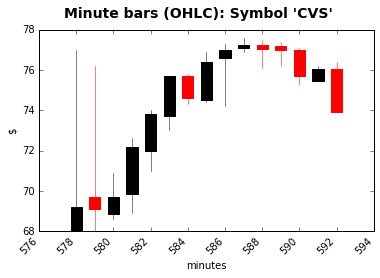

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.finance import candlestick_ohlc

# Split the dimensions to get the minute co-ordinates
l1, l2 = zip(*mb1.index)
# unify into a nparray of tuples for use in candlestick graph
q2 = zip(l2, mb1.open, mb1.high, mb1.low, mb1.close)

fig, ax = plt.subplots()
fig.subplots_adjust(bottom=0.2)
fig.suptitle('Minute bars (OHLC): Symbol \'CVS\' ', fontsize=14, fontweight='bold')
ax.set_xlabel('minutes')
ax.set_ylabel('$')

candlestick_ohlc(ax, q2[15:30], width=0.6)

ax.autoscale_view()
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')

plt.show()

### Microsecond tick data example

In [28]:
option_quote = sdb.wrap_array('option_quote')
option_quote.schema

u"<seq:int64 NULL DEFAULT null COMPRESSION 'zlib',sub:uint8 NULL DEFAULT null COMPRESSION 'zlib',exch:uint8 NULL DEFAULT null COMPRESSION 'zlib',nsec:int64 NULL DEFAULT null COMPRESSION 'zlib',line:string NULL DEFAULT null COMPRESSION 'zlib',flag:int64 NULL DEFAULT null COMPRESSION 'zlib',bid:float NULL DEFAULT null COMPRESSION 'zlib',ask:float NULL DEFAULT null COMPRESSION 'zlib',bidsz:int32 NULL DEFAULT null COMPRESSION 'zlib',asksz:int32 NULL DEFAULT null COMPRESSION 'zlib',condition:string NULL DEFAULT null COMPRESSION 'zlib'> [secid=0:*,100000,0,dt=19800101:21991231,1,0,tm=0:8640000000,1000000,0,synth_seq=0:9999,100000,0]"

Use SciDB-Py SciDB Array Objects to store lazily evaluated AFL query

In [29]:
 starttm = np.int64(8.5*3600*100000)
 endtm   = np.int64(15*3600*100000)
 startdt = enddt = datetime.date(2015, 12, 4)
    
option_quote_between = afl.between(option_quote, 'null' ,int(startdt.strftime('%Y%m%d')),starttm ,0, 'null', int(enddt.strftime('%Y%m%d')), endtm, 'null')
option_quote_between.query

u'between(option_quote,null,20151204,3060000000,0,null,20151204,5400000000,null)'

Return the count of the "option_quote" array to a NumPy ndarray

In [32]:
print(option_quote_between.nonempty())

11245389864


### Simple aggregation example

In [11]:
 option_quote_between.aggregate('bidsz_max':'max(bidsz)').toarray()

array([ 4.])

### Cross_join example

The below example demonstrates the use of cross_join and other afl operators to join a time of interest with an array that contains the national best bid and offer

In [ ]:
    minsecid = 100000
    maxsecid = 1500000
    
    starttm = np.int64(8.5*3600*100000)
    endtm   = np.int64(15*3600*100000)
    
    startdt = enddt = datetime.date(2015, 12, 4)
    
    start = time.time()
    
    fill = sdb.wrap_array('fill')
    redim = afl.redimension(fill, '<pre1m:int64, value1:int64, value2:int64> [secid=0:*,100000,0, interval_id=0:*,10000,0]').eval()
    
    option_nbbo  = sdb.wrap_array('nbbo_option_data') 
    between_nbbo = afl.between(option_nbbo,minsecid,int(startdt.strftime('%Y%m%d')),starttm,0,maxsecid,int(enddt.strftime('%Y%m%d')),endtm,10000)
    
    pre1mprj     = afl.project(redim,'pre1m')
    joinarr      = afl.cross_join(between_nbbo, pre1mprj,'secid','secid').filter('tm < pre1m').apply('tm_attribute','tm')
    min_times    = afl.redimension(joinarr, '<lower_bound:int64 null> [secid=0:*,10000,0, interval_id=0:*,10000,0],max(tm_attribute) as lower_bound').eval()
     
    dataframe = min_times.todataframe()

### As Of Join example

The asof operator joins trade data with quote data. At time points where quote data is not available, the last known value is looked up and filled in. This is sometimes also called a 'last value carry forward' join or 'piecewise constant interpolation join'.
The syntax is:
asof(A, B [, aggrDim [, missingCode]])
where the inputs are:
A & B: two arrays that have the same dimensionality;
aggrDim: the dimension in A along which to find last_value. Default is the last dimension.
missingCode: the missing code to use, when an A record cannot be found. Default is 0.
Here is an example that joins trades and quotes for 'BAM'. We use the fact that we know the symbol index for BAM is 615 from the last example. In this example, we only choose the values with dummy dimension of 0 (see comments below).

In [4]:
symbol = 'BAM'
tkr[tkr == symbol].todataframe()

,symbol
symbol_index,
615,BAM


Next run some counts for the data for this symbol

In [5]:
print('Dimensions of trades and quotes arrays:')
print(trades.dim_names)
print('\n# of quotes for symbol = %s' % symbol)
q1 = quotes.between('null', 615, 'null', 0, 615, 'null')
print(q1.nonempty())
print('\n# of trades for symbol = %s' % symbol)
t1 = trades.between('null', 615, 'null', 0, 615, 'null')
print(t1.nonempty())

Dimensions of trades and quotes arrays:
[u'dummy', u'symbol_index', u'ms']

# of quotes for symbol = BAM
33447

# of trades for symbol = BAM
4362



Now note that the dimensions of the quotes and trades arrays did not have identical chunking in the first place.

In [ ]:
from re import search
print(search('\[.*\]', q1.schema).group(0))
print(search('\[.*\]', t1.schema).group(0))

[dummy=0:999,1000,0,symbol_index=0:*,10,0,ms=0:86399999,86400000,0]

[dummy=0:999,1000,0,symbol_index=0:*,100,0,ms=0:86399999,86400000,0]

We resolve this by redimension-ing the (smaller) trades subarray for selected symbol to the same dimension schema as the quotes subarray

In [6]:
t2 = t1.redimension("<price:double NULL DEFAULT null,volume:int64 NULL DEFAULT null,\
                    sequence_number:int64 NULL DEFAULT null,condition:string NULL DEFAULT null,\
                    exchange:string NULL DEFAULT null> \
                    [dummy=0:999,1000,0,symbol_index=0:*,10,0,ms=0:86399999,86400000,0]")

Next we run the asof join and make some simple checks:

In [7]:
asof1 = q1.asof(t2)
print('The head() of the trades array')
t1.todataframe().head()

The head() of the trades array


price  volume  sequence_number condition exchange
dummy symbol_index ms                                                         
0     615          34185171   38.9      91             3309        TI        P
                   34185172   39.0     100             3310       FT         T
                   34185173   38.8      91             3312        TI        T
                   34185950   38.8       9             3313        TI        T
                   34200381   39.8    9761             3695      O           N

The head() of the quotes array

In [16]:
print('The head() of the quotes array')
qhead = q1.todataframe().head(10)
qhead[['ask_price','bid_price']]

The head() of the quotes array


ask_price  bid_price
dummy symbol_index ms                            
0     615          25269846        0.0       36.6
                   25269850        0.0        0.0
                   28800370       51.5       42.6
                   34050049        0.0       37.1
                   34050060       39.4        0.0
                   34050068       46.0       38.0
                   34050074       45.2       40.6
                   34080013       46.6       28.1
                   34183007       41.6       37.8
                   34185948       42.0       37.8

In [9]:
print('\n# of elements in the joined result:')
print(asof1.nonempty())
foo = asof1.todataframe().head()
foo[['ask_price','ask_size','price','volume']]


# of elements in the joined result:
4362


ask_price  ask_size  price  volume
dummy symbol_index ms                                          
0     615          34185171       41.6         6   38.9      91
                   34185172       41.6         6   39.0     100
                   34185173       41.6         6   38.8      91
                   34185950       42.0         1   38.8       9
                   34200381       40.1         1   39.8    9761


$$\,$$

$$\,$$


References again
----
* https://github.com/Paradigm4/TAQ/blob/master/TAQ_ipynb.ipynb
* https://www.github.com/paradigm4/SciDB-py
* https://www.github.com/paradigm4/
* http://www.paradigm4.com

Thanks!
====